In [1]:
from postgres import Postgres

pg = Postgres()

results = pg.query(
    """
 SELECT 
	cmetadata->'sections' as text
    FROM langchain_pg_embedding 
	WHERE cmetadata @> '{"chunker": "sherpa"}' 
    AND LENGTH(cmetadata->>'sections'::TEXT) > 5
	LIMIT 5000;
                   
	"""
)
documents = [r[0] for r in results]

In [2]:
import spacy

import numpy as np

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")


def remove_place_names_and_stop_words(text):

    custom_phrases = [
        "Abberley",
        "Abbots Langley",
        "Aberford",
        "Ab Kettleby Parish",
        "Acle",
        "Acton",
        "Addingham",
        "Adel",
        "Alcester",
        "Alfold",
        "Cleobury Mortimer",
        "Corby Glen",
        "Cossington",
        "Elmswell",
        "Fulbourn",
        "Nether Whitacre",
        "Sawtry",
        "Strensall & Towthorpe",
        "The Three Parishes",
        "Totnes",
        "West Wittering",
        "Whaley Bridge",
        "Winchfield",
        "Winkfield",
    ]

    doc = nlp(text)
    # Remove place names and stop words
    filtered_tokens = [
        token.text for token in doc if token.ent_type_ != "GPE" and not token.is_stop
    ]

    # Reconstruct the filtered text
    filtered_text = " ".join(filtered_tokens)

    # Remove custom stop phrases (case insensitive)
    filtered_text_lower = filtered_text.lower()
    for phrase in custom_phrases:
        filtered_text_lower = filtered_text_lower.replace(phrase.lower(), "")

    # Split and join to remove extra spaces
    filtered_text = " ".join(filtered_text_lower.split())

    return filtered_text


processed_documents = [
    remove_place_names_and_stop_words(doc) for doc in documents]

In [3]:
from bertopic import BERTopic

print(processed_documents[0:50])

# Create a BERTopic model
topic_model = BERTopic()
topics, probabilities = topic_model.fit_transform(processed_documents)

# Print the topics
print(topic_model.get_topic_info())

/Users/jimmy/Projects/neighbourhood-plans-server/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['consultative draft – version 2 > 2 . introduction 7', 'consultative draft – version 2 > 3 . introduction parish 16', 'local policy > adopted local plan', 'consultative draft – version 2 > 5 . spatial strategy 28', 'consultative draft – version 2 > 6 . housing 34', 'consultative draft – version 2 > 7 . local character , heritage design 38', 'consultative draft – version 2 > 8 . local economy 45', 'consultative draft – version 2 > 9 . natural environment 50', 'consultative draft – version 2 > 10 . leisure community 58', 'consultative draft – version 2 > 11 . transport movement 66', 'consultative draft – version 2 > 12 . aspirational projects 73', 'consultative draft – version 2 > appendices', 'consultative draft – version 2 > 1 . executive summary > figure 1.1 parish', 'consultative draft – version 2 > list figures > 1.1 parish … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … 4', 'consultative draft – version 2 > list figures > 2.1 neighbourhood plan bo

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


     Topic  Count                                     Name  \
0       -1    521      -1_version_appendix_local_education   
1        0    146             0_400_photo_road_northfields   
2        1     69  1_facilities_community_wlw4_enhancement   
3        2     63     2_objectives_vision_objecves_visions   
4        3     60    3_employment_economy_business_tourism   
..     ...    ...                                      ...   
103    102     11           102_staithes_coal_actions_site   
104    103     11       103_covered_description_22_history   
105    104     11       104_views_issues_movement_planning   
106    105     10          105_34_climate_change_rationale   
107    106     10      106_glossary_core_strategy_appendix   

                                        Representation  \
0    [version, appendix, local, education, training...   
1    [400, photo, road, northfields, view, located,...   
2    [facilities, community, wlw4, enhancement, ww1...   
3    [objectives, visio

In [5]:
from transformers import BertModel, BertTokenizer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_embedding(text):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()


embeddings = [get_embedding(doc) for doc in processed_documents]
embeddings = np.vstack(embeddings)

/Users/jimmy/Projects/neighbourhood-plans-server/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Silhouette Score: 0.058046434074640274


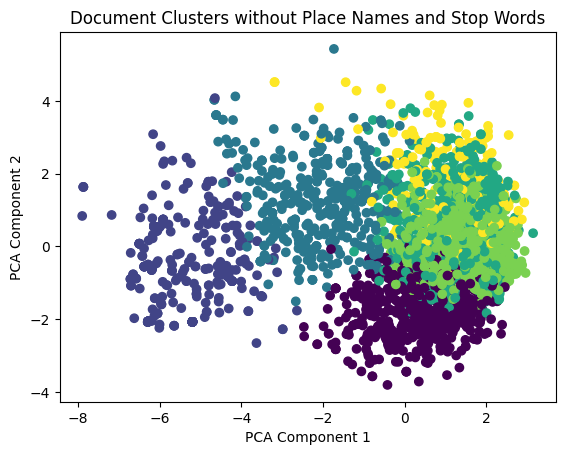

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

num_clusters = 6  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings)

# Evaluate
silhouette_avg = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Visualize
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters)
plt.title("Document Clusters without Place Names and Stop Words")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

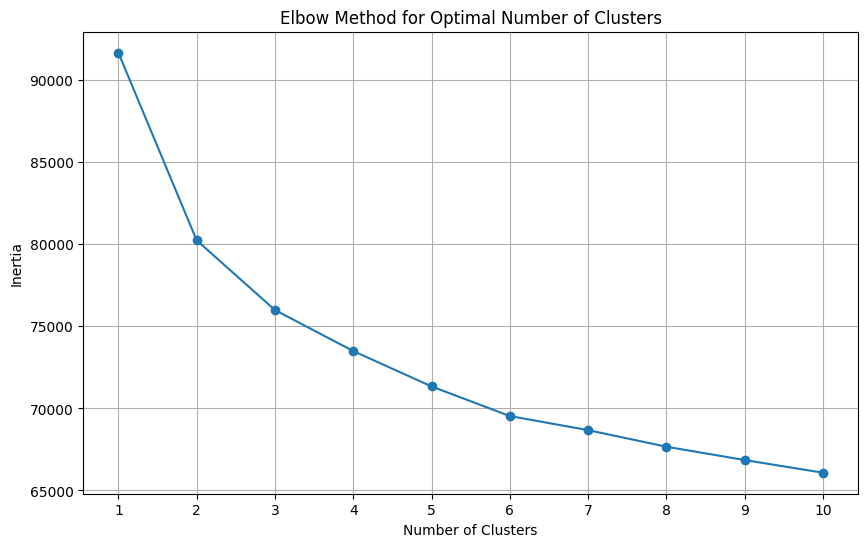

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming embeddings is a numpy array of the document embeddings

# List to store the inertia values for different numbers of clusters
inertia_values = []

# Range of clusters to try
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker="o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

Estimated number of clusters: 304
Estimated number of noise points: 2257


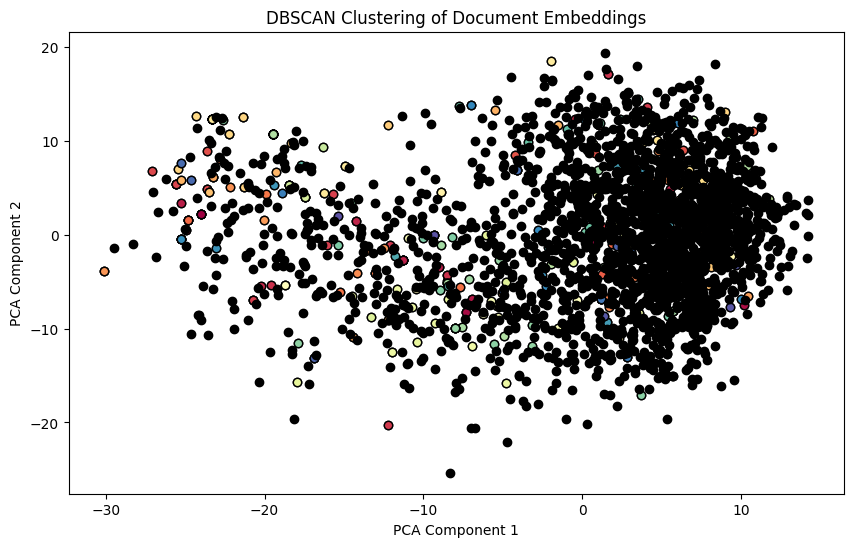

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming embeddings is a numpy array of the document embeddings

# Standardize the embeddings (DBSCAN works better with standardized data)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(embeddings_scaled)

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Visualize the clusters
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

plt.figure(figsize=(10, 6))
unique_labels = set(clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = clusters == k

    xy = reduced_embeddings[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("DBSCAN Clustering of Document Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [8]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

# Standardize the embeddings (DBSCAN works better with standardized data)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(embeddings_scaled)

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(clusters)
if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label if present

# Sample 5 examples from each cluster
sampled_examples = {}

for label in unique_labels:
    cluster_indices = np.where(clusters == label)[0]
    if len(cluster_indices) > 0:
        sampled_indices = random.sample(
            list(cluster_indices), min(5, len(cluster_indices))
        )
        sampled_examples[label] = [processed_documents[i] for i in sampled_indices]

# Print the sampled examples
for label, examples in sampled_examples.items():
    print(f"Cluster {label}:")
    for i, example in enumerate(examples):
        print(f"  Example {i+1}: {example}")
    print("\n")

Cluster 0:
  Example 1: consultative draft – version 2 > 1 . executive summary > figure 1.1 parish
  Example 2: consultative draft – version 2 > 1 . executive summary > figure 1.1 parish


Cluster 1:
  Example 1: glossary
  Example 2: glossary
  Example 3: glossary
  Example 4: glossary
  Example 5: glossary


Cluster 2:
  Example 1: 3 . introduction parish > brief history parish
  Example 2: 3 . introduction parish > brief history parish


Cluster 3:
  Example 1: neighbourhood plan - consultative draft , july 2021 > community - led hub
  Example 2: neighbourhood plan - consultative draft , july 2021 > community - led hub


Cluster 4:
  Example 1: 5 . spatial strategy > local factors affecting new development
  Example 2: 5 . spatial strategy > local factors affecting new development


Cluster 5:
  Example 1: neighbourhood plan - consultative draft , july 2021
  Example 2: neighbourhood plan - consultative draft , july 2021
  Example 3: neighbourhood plan - consultative draft , july 20

Cluster 0:
  Example 1: Policies > 3. Policies > 3.1 Overview > 3.2 Employment and Housing > Purpose
  Example 2: Fulbourn Neighbourhood Plan > Contents > Neighbourhood Plan Policies 33
  Example 3: Dark Skies > Evidence
  Example 4: CG16 - Community Halls > Explanation
  Example 5: Appendix B > Glossary > Highway authority


Cluster 1:
  Example 1: Higher level policies for Objective A
  Example 2: The Village Today
  Example 3: 7. Delivery and Monitoring
  Example 4: Sustainable development
  Example 5: Vision and Objectives


Cluster 2:
  Example 1: Policy 6: Improving Access to the Wherry Line
  Example 2: Existing Community Facilities
  Example 3: National Garden Scheme
  Example 4: Natural Greenspace and Biodiversity
  Example 5: Appendix 2: List of Appropriate Trees for Fulbourn


Cluster 3:
  Example 1: 4.00 CHARACTER AREAS > 7. Ox Carr Lane
  Example 2: 5.0 Non-Statutory Community Aspirations > 6.0 Delivery Plan > Monitoring and Review of the Neighbourhood Plan > APPENDIX 1 – 

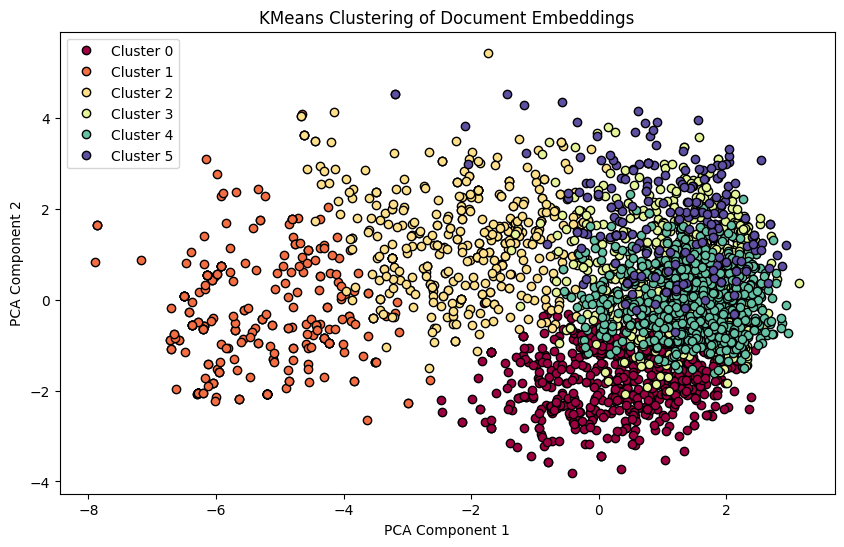

In [10]:
# Perform KMeans clustering
num_clusters = 6  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings)

# Sample 5 examples from each cluster
sampled_examples = {}

for label in set(clusters):
    cluster_indices = np.where(clusters == label)[0]
    if len(cluster_indices) > 0:
        sampled_indices = random.sample(
            list(cluster_indices), min(5, len(cluster_indices))
        )
        sampled_examples[label] = [documents[i] for i in sampled_indices]

# Print the sampled examples
for label, examples in sampled_examples.items():
    print(f"Cluster {label}:")
    for i, example in enumerate(examples):
        print(f"  Example {i+1}: {example}")
    print("\n")

# Visualize the clusters
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, num_clusters)]
for k, col in zip(range(num_clusters), colors):
    class_member_mask = clusters == k
    xy = reduced_embeddings[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
        label=f"Cluster {k}",
    )

plt.title("KMeans Clustering of Document Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [19]:
from postgres import Postgres

pg = Postgres()

results = pg.query(
    """
 SELECT 
	DISTINCT cmetadata->'neighbourhood' as text
    FROM langchain_pg_embedding 
	WHERE cmetadata @> '{"chunker": "sherpa"}' 
    
	LIMIT 5000;
                   
	"""
)
documents = [r[0] for r in results]

In [20]:
print(documents)

['Abberley', 'Abbots Langley', 'Aberford', 'Ab Kettleby Parish', 'Acle', 'Acton', 'Addingham', 'Adel', 'Alcester', 'Alfold', 'Cleobury Mortimer', 'Corby Glen', 'Cossington', 'Elmswell', 'Fulbourn', 'Nether Whitacre', 'Sawtry', 'Strensall & Towthorpe', 'The Three Parishes', 'Totnes', 'West Wittering', 'Whaley Bridge', 'Winchfield', 'Winkfield']
